## Classification Bake-off:

The goal of this bake off if for students to practice the data science process and handling . Through this process, you will need to clean and prepare the data, engineer features, fit didfferent models, tune the hyperparameters of those models, and account for how any class imbalance can affect your model. 

## Data Set Information:

This dataset contains information about customers' credit card default payments in Taiwan. It was taken from a study that compares the predictive accuracy of probability of default among six data mining methods. This data set is not as clean as some of the data you have previously recieved. Below is all of the information that is given about the different columns of data. As you explore this data you will find that the 'data dictionary' below does not include all of the values that you will find in the actual dataset. You will have to make decisions on your own as to how you will interpret and handle these unknown values.  

## Evaluation:

For this bake-off, we will be scoring the submitted predictions using the F1 score. 


## Attribute Information:

This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:
- X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
- X2: Gender (1 = male; 2 = female).
- X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
- X4: Marital status (1 = married; 2 = single; 3 = others).
- X5: Age (year).
- X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows:
    - X6 = the repayment status in September, 2005;
    - X7 = the repayment status in August, 2005; . . .;
    - X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
- X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
- X18-X23: Amount of previous payment (NT dollar).
    - X18 = amount paid in September, 2005;
    - X19 = amount paid in August, 2005; . . .;
    - X23 = amount paid in April, 2005.

# Import Data

In [178]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [179]:
train_df = pd.read_csv('dataset.csv', index_col='Unnamed: 0')
train_df.shape

(22500, 24)

In [180]:
hold_df = pd.read_csv('validation_set.csv', index_col='Unnamed: 0')
hold_df.shape

(7500, 23)

# Create Features

In [181]:
# Function to rename credit limit, default, payment status, balance and payment amount columns
def rename_cols(df):
    if 'default payment next month' in df.keys():
        df = df.rename(columns={'default payment next month': 'DEFAULT'})
    df = df.rename(columns={'LIMIT_BAL': 'CREDIT_LIM'})
    df = df.rename(columns={'PAY_0': 'SEP_STS', 'PAY_2': 'AUG_STS', 'PAY_3': 'JUL_STS',
                            'PAY_4': 'JUN_STS', 'PAY_5': 'MAY_STS', 'PAY_6': 'APR_STS'})
    df = df.rename(columns={'BILL_AMT1': 'SEP_BAL', 'BILL_AMT2': 'AUG_BAL', 'BILL_AMT3': 'JUL_BAL',
                            'BILL_AMT4': 'JUN_BAL', 'BILL_AMT5': 'MAY_BAL', 'BILL_AMT6': 'APR_BAL'})
    df = df.rename(columns={'PAY_AMT1': 'SEP_PMT', 'PAY_AMT2': 'AUG_PMT', 'PAY_AMT3': 'JUL_PMT',
                            'PAY_AMT4': 'JUN_PMT', 'PAY_AMT5': 'MAY_PMT', 'PAY_AMT6': 'APR_PMT'})
    return df

In [182]:
# Function to transform extreme values
def adj_outliers(df, outlier_cols):
    for col in outlier_cols:
        std = df[col].std()
        mean = df[col].mean()
        value = mean + (5 * std)
        df[col] = df[col].apply(lambda x: value if (x>value) else x)
    return df

In [183]:
# Function to turn sex data into male dummy column
def dummies_sex(df):
    filt = df['SEX'] == 1
    df['SEX_M'] = np.where(filt, 1, 0)
    df.drop('SEX', axis=1, inplace=True)
    return df

In [184]:
# Function to turn education data into dummy columns
def dummies_edu(df):
    df['EDUCATION'] = df['EDUCATION'].map({1: 'GS', 2: 'UNI', 3: 'HS', 4: 'OTH',
                                           0: '0_UNK', 5: '5_UNK', 6: '6_UNK'})
    dummies = pd.get_dummies(df['EDUCATION'], prefix='EDU', drop_first=False)
    df = pd.concat([df, dummies], axis=1)
    df.drop(['EDUCATION', 'EDU_0_UNK'], axis=1, inplace=True)
    return df

In [185]:
# Function to turn marital status data into dummy columns
def dummies_ms(df):
    df['MARRIAGE'] = df['MARRIAGE'].map({1: 'MAR', 2: 'SGL', 3: 'DIV', 0: '0_UNK'})
    dummies = pd.get_dummies(df['MARRIAGE'], prefix='MS', drop_first=False)
    df = pd.concat([df, dummies], axis=1)
    df.drop(['MARRIAGE', 'MS_0_UNK'], axis=1, inplace=True)
    return df

In [186]:
# Function to turn payment status data into dummy columns
def dummies_sts(df):
    for m in ['SEP', 'AUG', 'JUL', 'JUN', 'MAY', 'APR']:
        df[f'{m}_PAID_ALL'] = np.where(df[f'{m}_STS'] == -2, 1, 0)
        df[f'{m}_PAID_BAL'] = np.where(df[f'{m}_STS'] == -1, 1, 0)
        df[f'{m}_PAID_MIN'] = np.where(df[f'{m}_STS'] == 0, 1, 0)
        df[f'{m}_DEL_1'] = np.where(df[f'{m}_STS'] == 1, 1, 0)
        df[f'{m}_DEL_2'] = np.where(df[f'{m}_STS'] == 2, 1, 0)
        df[f'{m}_DEL_3'] = np.where(df[f'{m}_STS'] == 3, 1, 0)
        df[f'{m}_DEL_4'] = np.where(df[f'{m}_STS'] == 4, 1, 0)
        df[f'{m}_DEL_5'] = np.where(df[f'{m}_STS'] == 5, 1, 0)
        df[f'{m}_DEL_6'] = np.where(df[f'{m}_STS'] == 6, 1, 0)
        df[f'{m}_DEL_7'] = np.where(df[f'{m}_STS'] == 7, 1, 0)
        df[f'{m}_DEL_8'] = np.where(df[f'{m}_STS'] == 8, 1, 0)
        df[f'{m}_DEL_9'] = np.where(df[f'{m}_STS'] == 9, 1, 0)
        df.drop([f'{m}_STS', f'{m}_PAID_ALL'], axis=1, inplace=True)
    return df

In [187]:
# Function to calculate mean credit available and credit usage per customer
def credit_usage(df):
    copy = df.copy()
    for m in ['SEP', 'AUG', 'JUL', 'JUN', 'MAY', 'APR']:
        copy[f'{m}_CRD_AVL'] = copy['CREDIT_LIM'] - copy[f'{m}_BAL']
        copy[f'{m}_CRD_USG'] = 100 * copy[f'{m}_BAL'] / copy['CREDIT_LIM']
    df['MN_CRD_AVL'] = copy[['SEP_CRD_AVL', 'AUG_CRD_AVL', 'JUL_CRD_AVL', 'JUN_CRD_AVL',
                             'MAY_CRD_AVL', 'APR_CRD_AVL']].mean(axis=1)
    df['MN_CRD_USG'] = copy[['SEP_CRD_USG', 'AUG_CRD_USG', 'JUL_CRD_USG', 'JUN_CRD_USG',
                             'MAY_CRD_USG', 'APR_CRD_USG']].mean(axis=1)
    del copy
    return df

In [188]:
# Function to calculate mean payment as percentage of balance per customer
def payment_pct(df):
    copy = df.copy()
    for m in ['SEP', 'AUG', 'JUL', 'JUN', 'MAY', 'APR']:
        filt = copy[f'{m}_BAL'] > 0
        copy[f'{m}_PMT_PCT'] = np.where(filt, (100 * copy[f'{m}_PMT'] / copy[f'{m}_BAL']), 100)
    df['MN_PMT_PCT'] = copy[['SEP_PMT_PCT', 'AUG_PMT_PCT', 'JUL_PMT_PCT', 'JUN_PMT_PCT',
                             'MAY_PMT_PCT', 'APR_PMT_PCT']].mean(axis=1)
    del copy
    return df

In [189]:
# Function to calculate distance from and percentage of the mean credit limit
def compare_lims(df, mean_lim):
    df['LIM_DST_MN'] = df['CREDIT_LIM'] - mean_lim
    df['LIM_PCT_MN'] = 100 * df['CREDIT_LIM'] / mean_lim
    return df

# Apply Features to Dataframes

In [190]:
# Function to apply all features to dataframes
def create_features(df, outlier_cols, mean_lim):
    df = rename_cols(df)
    df = adj_outliers(df, outlier_cols)
    df = dummies_sex(df)
    df = dummies_edu(df)
    df = dummies_ms(df)
    df = dummies_sts(df)
    df = credit_usage(df)
    df = payment_pct(df)
    df = compare_lims(df, mean_lim)
    return df

# Columns containing outliers to be adjusted
outlier_cols = ['CREDIT_LIM', 'SEP_BAL', 'AUG_BAL', 'JUL_BAL', 'JUN_BAL', 'MAY_BAL', 'APR_BAL',
                'SEP_PMT', 'AUG_PMT', 'JUL_PMT', 'JUN_PMT', 'MAY_PMT', 'APR_PMT']

# Mean credit limit of combined dataframes
mean_lim = 167478

# Apply features to dataframes
train_df = create_features(train_df, outlier_cols, mean_lim)
hold_df = create_features(hold_df, outlier_cols, mean_lim)

In [191]:
# Function to drop columns where all values are 0
def drop_empties(df):
    empties = [col for col in df.loc[:, (df == 0).all(axis=0)]]
    df.drop(columns=empties, axis=1, inplace=True)
    return df

# Drop columns where all values are 0
train_df = drop_empties(train_df)
hold_df = drop_empties(hold_df)

In [192]:
# Function to compare two dataframes, assign values of 0 to any missing columns
def compare_cols(df1, df2):
    for col in df1:
        if col in df2:
            pass
        else:
            df2[col] = 0
    for col in df2:
        if col in df1:
            pass
        else:
            df1[col] = 0
    return df1, df2

# Compare columns of dataframes, then drop default column from holdout data
train_df, hold_df = compare_cols(train_df, hold_df)
hold_df.drop('DEFAULT', axis=1, inplace=True)

In [193]:
train_df.keys()

Index(['CREDIT_LIM', 'AGE', 'SEP_BAL', 'AUG_BAL', 'JUL_BAL', 'JUN_BAL',
       'MAY_BAL', 'APR_BAL', 'SEP_PMT', 'AUG_PMT', 'JUL_PMT', 'JUN_PMT',
       'MAY_PMT', 'APR_PMT', 'DEFAULT', 'SEX_M', 'EDU_5_UNK', 'EDU_6_UNK',
       'EDU_GS', 'EDU_HS', 'EDU_OTH', 'EDU_UNI', 'MS_DIV', 'MS_MAR', 'MS_SGL',
       'SEP_PAID_BAL', 'SEP_PAID_MIN', 'SEP_DEL_1', 'SEP_DEL_2', 'SEP_DEL_3',
       'SEP_DEL_4', 'SEP_DEL_5', 'SEP_DEL_6', 'SEP_DEL_7', 'SEP_DEL_8',
       'AUG_PAID_BAL', 'AUG_PAID_MIN', 'AUG_DEL_1', 'AUG_DEL_2', 'AUG_DEL_3',
       'AUG_DEL_4', 'AUG_DEL_5', 'AUG_DEL_6', 'AUG_DEL_7', 'JUL_PAID_BAL',
       'JUL_PAID_MIN', 'JUL_DEL_1', 'JUL_DEL_2', 'JUL_DEL_3', 'JUL_DEL_4',
       'JUL_DEL_5', 'JUL_DEL_6', 'JUL_DEL_7', 'JUL_DEL_8', 'JUN_PAID_BAL',
       'JUN_PAID_MIN', 'JUN_DEL_1', 'JUN_DEL_2', 'JUN_DEL_3', 'JUN_DEL_4',
       'JUN_DEL_5', 'JUN_DEL_6', 'JUN_DEL_7', 'JUN_DEL_8', 'MAY_PAID_BAL',
       'MAY_PAID_MIN', 'MAY_DEL_2', 'MAY_DEL_3', 'MAY_DEL_4', 'MAY_DEL_5',
       'MAY_DEL_6', 'MA

# EDA

In [149]:
# Percentage of borrowers who defaulted
dft_pct = len(train_df[train_df['DEFAULT'] == 1])/len(train_df)
dft_pct

0.2212

In [150]:
# Mean credit limit of combined dataframes
int(round(pd.concat([train_df, hold_df])['CREDIT_LIM'].mean()))

167478

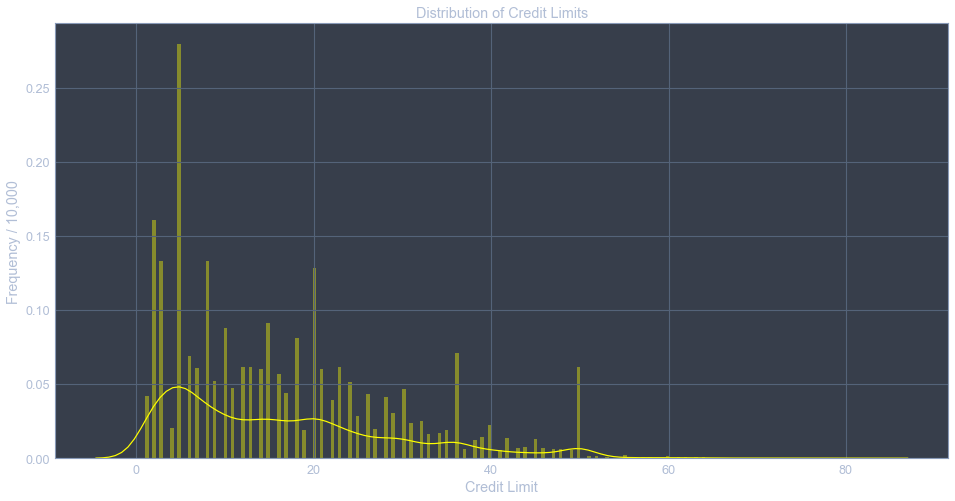

In [19]:
# Function to plot distribution of credit limits
def plot_limit_dist(df):
    plt.figure(figsize = (16,8))
    sns.distplot(df['CREDIT_LIM']/10000, bins = 200, color='yellow')
    plt.title('Distribution of Credit Limits')
    plt.xlabel('Credit Limit')
    plt.ylabel('Frequency / 10,000')
    return plt.show()

plot_limit_dist(train_df)

/Users/eric/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


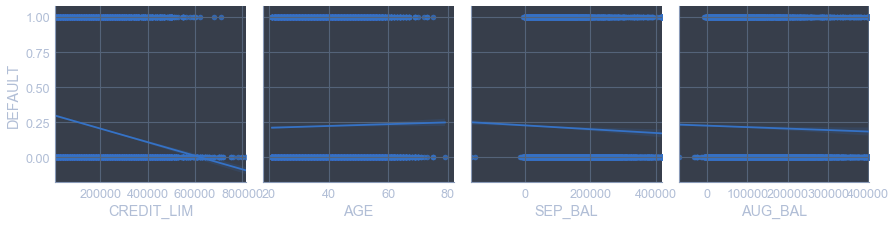

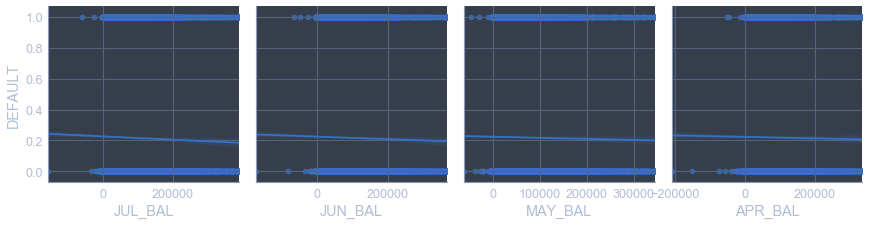

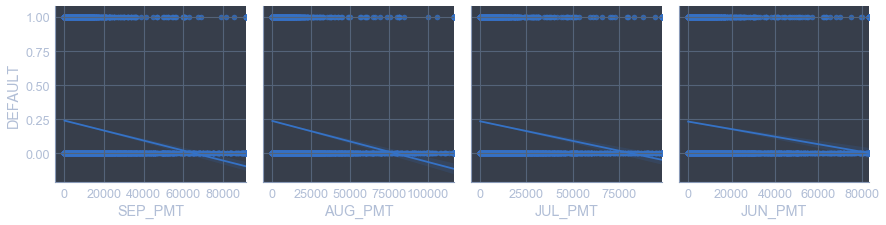

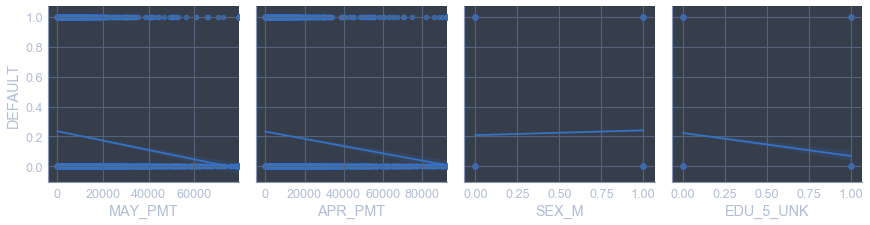

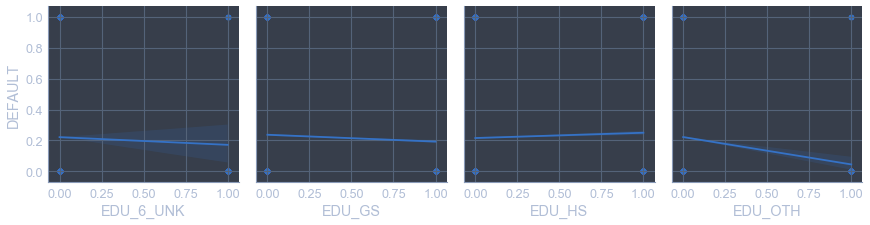

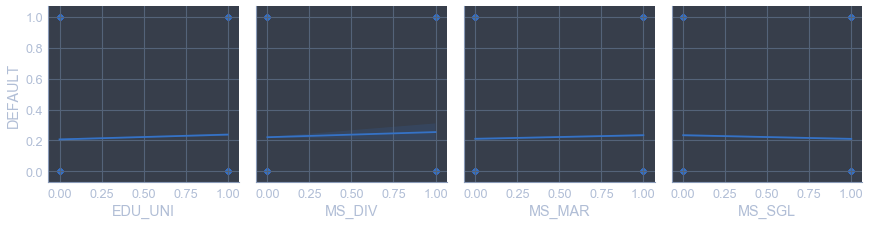

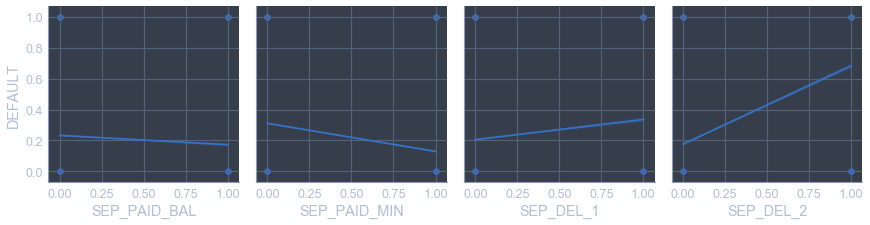

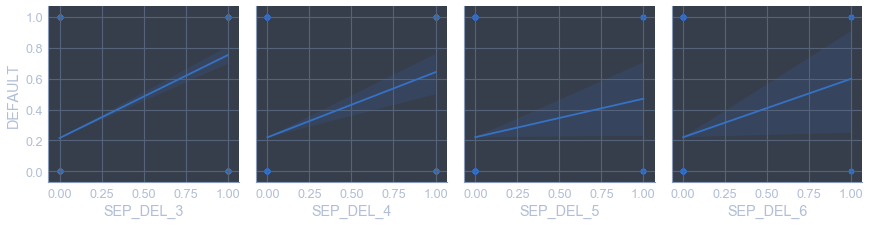

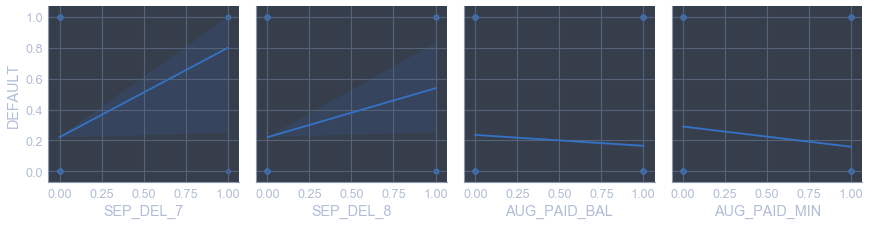

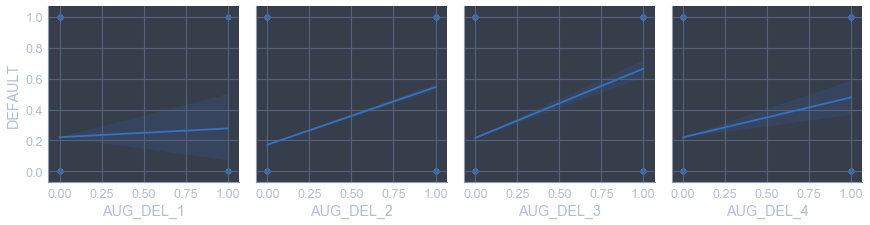

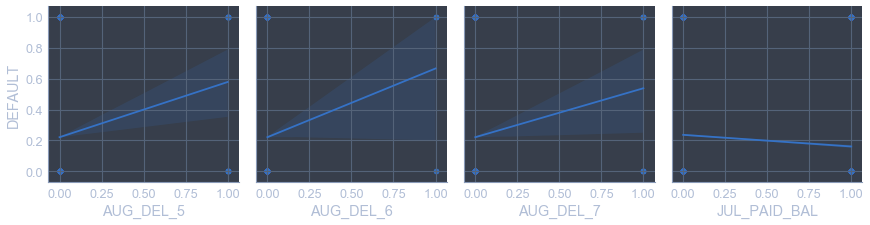

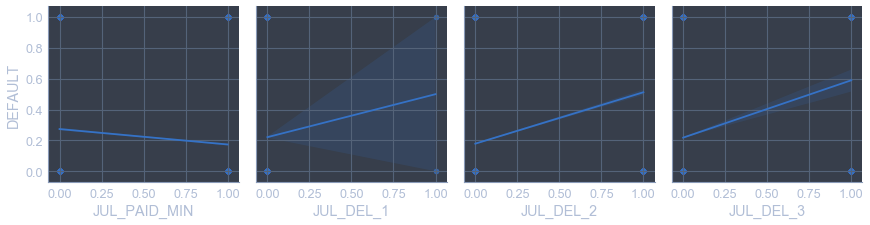

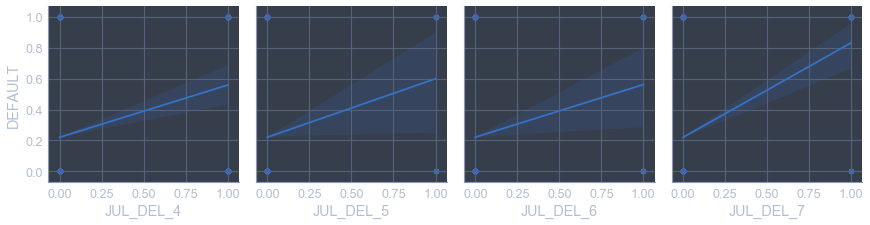

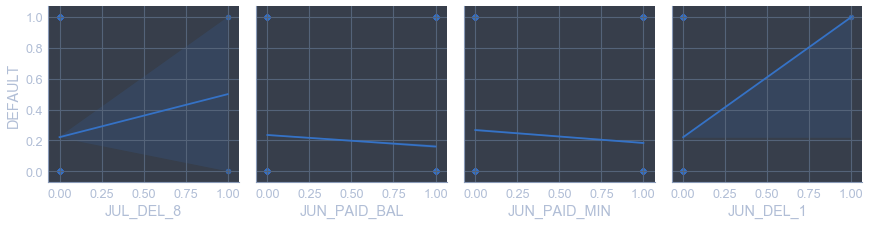

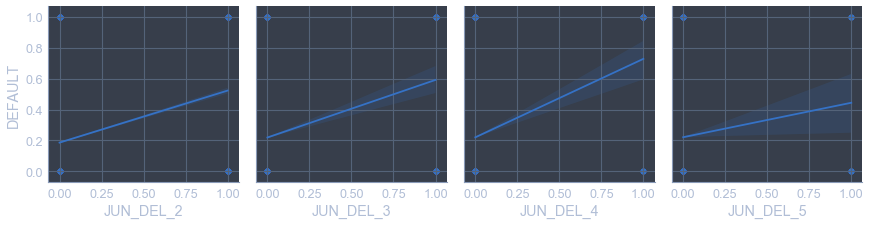

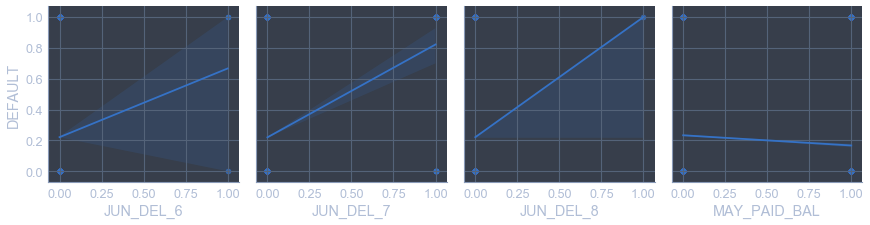

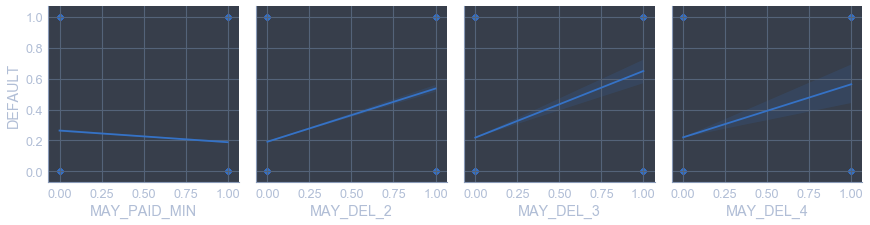

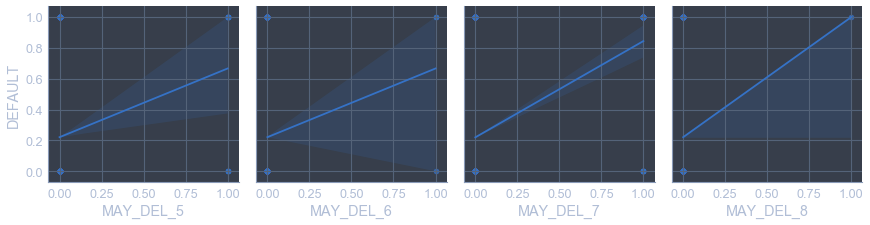

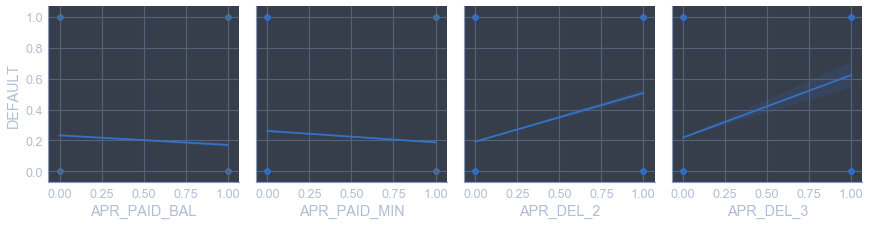

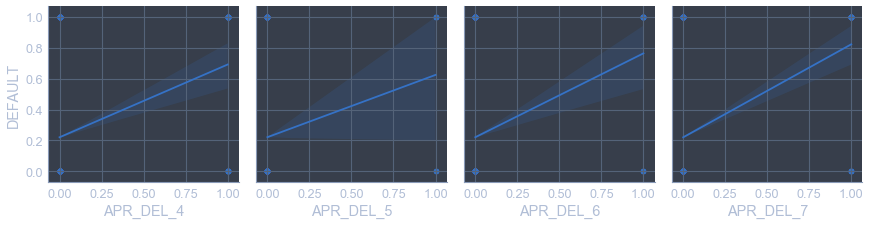

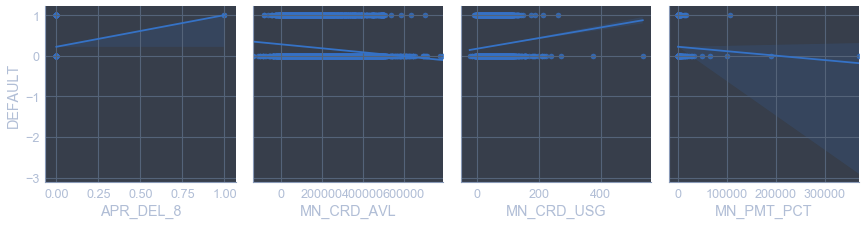

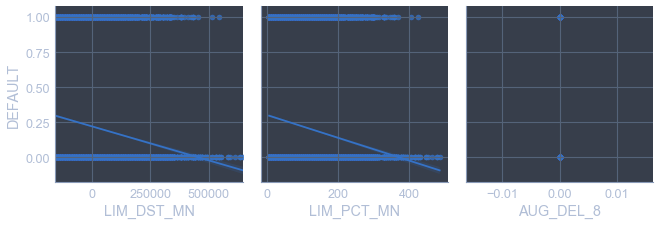

In [44]:
# Function to plot each feature vs target variable
def pplot_features(df, features):
    pp_rows = [features[i:i+4] for i in range(0, len(features), 4)]
    for row in pp_rows:
        pp = sns.pairplot(data=df, y_vars=['DEFAULT'], x_vars=row, kind='reg', height=3)
    return plt.show()

pplot_features(train_df, train_df.drop(columns='DEFAULT').keys())

In [20]:
# Function to create correlation matrix
def corr_matrix(df):
    corr = train_df.corr()
    return corr.style.background_gradient(cmap='coolwarm').set_precision(2)

corr_matrix(train_df)

/Users/eric/opt/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/pandas/io/formats/style.py:1089: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/pandas/io/formats/style.py:1090: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


# Train/Test Split

In [194]:
# Fucntion to split data into train and test data
def tt_split(df):
    X = df.drop(columns=['DEFAULT'], axis=1)
    y = df['DEFAULT']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    return X_train, X_test, y_train, y_test

# Split training data into train and test data
X_train, X_test, y_train, y_test = tt_split(train_df)

X_train.shape, X_test.shape

((18000, 87), (4500, 87))

# Standard Scalar

In [195]:
# Function to apply standard scalar
def std_sclr(df):
    scale = StandardScaler()
    trans = scale.fit_transform(df)
    return pd.DataFrame(trans, columns=df.columns)

# Transform x train and test data
X_train_scl = std_sclr(X_train)
X_test_scl = std_sclr(X_test)

# Dummy Classifier

In [196]:
clf = DummyClassifier()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.6584444444444445

# Logistic Regression

In [197]:
# Function to fit logistic regression model
def lr(X_train, y_train):
    lr = LogisticRegression()
    lr_fit = lr.fit(X_train, y_train)
    return lr_fit

In [198]:
# Fit logistic regression model on train data, predict on test data
lr_fit = lr(X_train, y_train)
lr_pred = lr_fit.predict(X_test)

# F1 score of logistic regression predictions
f1_score(lr_pred, y_test)

/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.0019743336623889436

In [199]:
# Fit logistic regression model on scaled train data, predict on scaled test data
lr_fit_scl = lr(X_train_scl, y_train)
lr_pred_scl = lr_fit.predict(X_test_scl)

# F1 score of scaled logistic regression predictions
f1_score(lr_pred_scl, y_test)

/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.3980123047799337

In [200]:
pd.DataFrame(lr_pred_scl)[0].value_counts()

1    3215
0    1285
Name: 0, dtype: int64

# Random Forest

In [204]:
# Function to fit random forest model
def rf(X_train, y_train):
    rf = RandomForestClassifier(n_jobs=4, random_state=1, n_estimators=100)
    rf_fit = rf.fit(X_train, y_train)
    return rf_fit

In [209]:
# Fit random forest model on train data, predict on test data
rf_fit = rf(X_train, y_train)
rf_preds = rf_fit.predict(X_test)

# F1 score of random forest predictions
f1_score(rf_preds, y_test)

0.46274509803921576

In [210]:
# Fit random forest model on scaled train data, predict on scaled test data
rf_fit_scl = rf(X_train_scl, y_train)
rf_preds_scl = rf_fit.predict(X_test_scl)

# F1 score of scaled random forest predictions
f1_score(rf_preds_scl, y_test)

0.44272274488101826

# Grid Search

In [26]:
c_range = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
penalty= ['l2','l1']
solver = ['liblinear']
param_grid = dict(C=c_range, penalty=penalty, max_iter=[100, 1000, 2500, 5000], solver=solver)

In [ ]:
grid = GridSearchCV(LogisticRegression(penalty=penalty), n_jobs=4, param_grid, scoring='f1', cv=3, verbose=1)
grid.fit(X_train_tnsf, y_train)

Fitting 3 folds for each of 56 candidates, totalling 168 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

In [75]:
penalty = ['l2']
c_range = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
solver = ['liblinear']
param_grid = dict(C=c_range, penalty=penalty, max_iter=[100, 1000,2500, 5000], solver=solver)
grid = GridSearchCV(LogisticRegression(penalty=penalty), param_grid, scoring='f1', cv=3, verbose=1)
grid.fit(X_train, y_train)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:    9.9s finished


GridSearchCV(cv=3, estimator=LogisticRegression(penalty=['l2']),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'max_iter': [100, 1000, 2500, 5000], 'penalty': ['l2'],
                         'solver': ['liblinear']},
             scoring='f1', verbose=1)

In [76]:
pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,0.000499,0.000705,"{'C': 0.001, 'max_iter': 100, 'penalty': 'l2',..."
1,0.000499,0.000705,"{'C': 0.001, 'max_iter': 1000, 'penalty': 'l2'..."
2,0.000499,0.000705,"{'C': 0.001, 'max_iter': 2500, 'penalty': 'l2'..."
3,0.000499,0.000705,"{'C': 0.001, 'max_iter': 5000, 'penalty': 'l2'..."
4,0.000499,0.000705,"{'C': 0.01, 'max_iter': 100, 'penalty': 'l2', ..."
5,0.000499,0.000705,"{'C': 0.01, 'max_iter': 1000, 'penalty': 'l2',..."
6,0.000499,0.000705,"{'C': 0.01, 'max_iter': 2500, 'penalty': 'l2',..."
7,0.000499,0.000705,"{'C': 0.01, 'max_iter': 5000, 'penalty': 'l2',..."
8,0.000499,0.000705,"{'C': 0.1, 'max_iter': 100, 'penalty': 'l2', '..."
9,0.000499,0.000705,"{'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', ..."


In [77]:
def grid_search(X_train, X_test, y_train, y_test):
    params = {'C': [.001, .01, .1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']}
    grid = GridSearchCV(LogisticRegression(), param_grid=params, scoring='f1', verbose=1, cv=3)
    grid.fit(X_train, y_train)
    return grid

grid2 = grid_search(X_train, X_test, y_train, y_test)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1302, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/eric/opt/anaconda

/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users

In [78]:
pd.DataFrame(grid2.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,NaN,NaN,"{'C': 0.001, 'penalty': 'l1'}"
1,0.000499,0.000705,"{'C': 0.001, 'penalty': 'l2'}"
2,NaN,NaN,"{'C': 0.01, 'penalty': 'l1'}"
3,0.000499,0.000705,"{'C': 0.01, 'penalty': 'l2'}"
4,NaN,NaN,"{'C': 0.1, 'penalty': 'l1'}"
5,0.000499,0.000705,"{'C': 0.1, 'penalty': 'l2'}"
6,NaN,NaN,"{'C': 1, 'penalty': 'l1'}"
7,0.000499,0.000705,"{'C': 1, 'penalty': 'l2'}"
8,NaN,NaN,"{'C': 10, 'penalty': 'l1'}"
9,0.000499,0.000705,"{'C': 10, 'penalty': 'l2'}"


# Unused Functions

In [37]:
# # Function to calculate credit available and credit usage
# def credit_usage(df):
#     for m in ['SEP', 'AUG', 'JUL', 'JUN', 'MAY', 'APR']:
#         df[f'{m}_CRD_AVL'] = df['CREDIT_LIM'] - df[f'{m}_BAL']
#         df[f'{m}_CRD_USG'] = 100 * df[f'{m}_BAL'] / df['CREDIT_LIM']
#     return df

In [ ]:
# def gridsearch(X_train_data, X_test_data, y_train_data, y_test_data, model, param_grid,
#                cv=10, scoring_fit='neg_mean_squared_error', do_probabilities = False):
#     gs = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv,
#                       n_jobs=-1, scoring=scoring_fit, verbose=2)
#     fitted_model = gs.fit(X_train_data, y_train_data)
#     if do_probabilities:
#         pred = fitted_model.predict_proba(X_test_data)
#     else:
#         pred = fitted_model.predict(X_test_data)
#     return fitted_model, pred